<a href="https://colab.research.google.com/github/nazma98/NLP-based-Email-Content-Digital-Forensic-using-ML-model-and-Explainable-AI/blob/main/enron_email_content_forensic_Federated_learning_approach_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import torch
#import syft as sy
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.metrics import classification_report

In [4]:
# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/merged_topic_features_labeled.csv')

In [5]:
df.head()

,Unnamed: 0,doc_id,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14,labeled
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,1,1,0,0,0,2,0,0,0,0,0,22,0,1,1,0,0,False
2,2,2,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,False
3,3,3,2,1,0,2,1,4,3,0,1,3,1,0,0,1,1,False
4,4,4,1,17,1,40,7,4,16,1,2,32,14,105,21,1,5,False


In [6]:
df.columns


Index(['Unnamed: 0', 'doc_id', 'topic 0', 'topic 1', 'topic 2', 'topic 3',
       'topic 4', 'topic 5', 'topic 6', 'topic 7', 'topic 8', 'topic 9',
       'topic 10', 'topic 11', 'topic 12', 'topic 13', 'topic 14', 'labeled'],
      dtype='object')

In [7]:
# List of all features
features = [
    'topic 0', 'topic 1', 'topic 2', 'topic 3',
       'topic 4', 'topic 5', 'topic 6', 'topic 7', 'topic 8', 'topic 9',
       'topic 10', 'topic 11', 'topic 12', 'topic 13', 'topic 14'
]


In [8]:
print(df.columns)

Index(['Unnamed: 0', 'doc_id', 'topic 0', 'topic 1', 'topic 2', 'topic 3',
       'topic 4', 'topic 5', 'topic 6', 'topic 7', 'topic 8', 'topic 9',
       'topic 10', 'topic 11', 'topic 12', 'topic 13', 'topic 14', 'labeled'],
      dtype='object')


In [9]:
df = df.dropna(subset=['labeled'])  # Drop rows with NaN in 'labeled' column

In [10]:
# Ensure 'legitimate' is the target
target = 'labeled'

# Separate features and target
X = df[features]
y = df[target]

In [11]:
# Convert the target variable to a numerical type
y = y.astype(int)  #'labeled' should be 0 or 1

In [12]:
y

0         0
1         0
2         0
3         0
4         0
         ..
515659    0
515660    0
515661    0
515662    0
515663    0
Name: labeled, Length: 513700, dtype: int64

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.int64)

# Address class imbalance with SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_tensor.numpy(), y_tensor.numpy())
X_tensor_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor_resampled = torch.tensor(y_resampled, dtype=torch.long)

# Combine into a TensorDataset
dataset = TensorDataset(X_tensor_resampled, y_tensor_resampled)

# Split the dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Calculate sizes for 4 clients, ensuring the sum matches train_size
client_base_size = train_size // 4
remaining = train_size - (client_base_size * 4)
client_sizes = [client_base_size] * 4

# Distribute the remaining samples to ensure the sum matches train_size
for i in range(remaining):
    client_sizes[i] += 1

# Further split the training data for 4 clients
client_datasets = random_split(train_dataset, client_sizes)

print([len(client_dataset) for client_dataset in client_datasets])  # Verify the sizes

# Check class distribution in the training set
train_labels = [int(y.item()) for _, y in train_dataset]
class_counts = Counter(train_labels)
print(class_counts)

# Define a more complex model
class MoreComplexNN(nn.Module):
    def __init__(self):
        super(MoreComplexNN, self).__init__()
        self.fc1 = nn.Linear(X_tensor.shape[1], 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

global_model = MoreComplexNN().to(device)

# Calculate class weights
class_weights = torch.tensor([1.0, class_counts[0] / class_counts[1]], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(global_model.parameters(), lr=0.001)

training_accuracies = []


# Train your model (simplified training loop)
for epoch in range(10):  # Adjust the number of epochs
    global_model.train()
    correct = 0
    total = 0
    for data, target in DataLoader(train_dataset, batch_size=32, shuffle=True):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = global_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = correct / total
    training_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Training Accuracy: {accuracy:.4f}')

# Evaluate the global model on the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
global_model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = global_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        all_preds.extend(predicted.tolist())
        all_targets.extend(target.tolist())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")



[179180, 179180, 179180, 179180]
Counter({0: 358481, 1: 358239})
Epoch 1, Loss: 0.5314273834228516, Training Accuracy: 0.6684
Epoch 2, Loss: 0.37800779938697815, Training Accuracy: 0.7838
Epoch 3, Loss: 0.5059495568275452, Training Accuracy: 0.8172
Epoch 4, Loss: 0.186772421002388, Training Accuracy: 0.8347
Epoch 5, Loss: 0.25173982977867126, Training Accuracy: 0.8465
Epoch 6, Loss: 0.5739980340003967, Training Accuracy: 0.8544
Epoch 7, Loss: 0.34990018606185913, Training Accuracy: 0.8610
Epoch 8, Loss: 0.3557142913341522, Training Accuracy: 0.8668
Epoch 9, Loss: 0.36031803488731384, Training Accuracy: 0.8707
Epoch 10, Loss: 0.2380792796611786, Training Accuracy: 0.8742
Test Accuracy: 0.8769


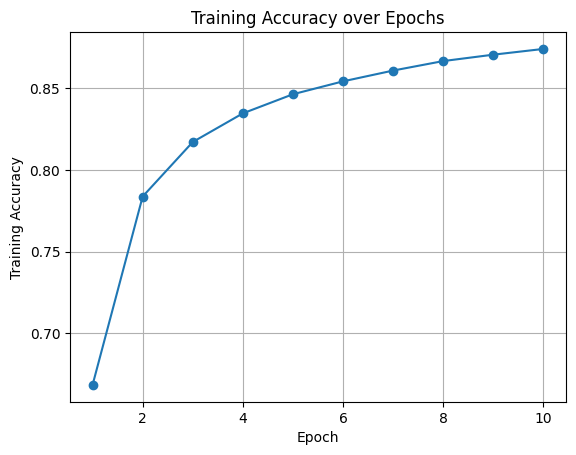

In [16]:
# Plot the training accuracy
plt.plot(range(1, 10 + 1), training_accuracies, marker='o')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.grid()
plt.show()

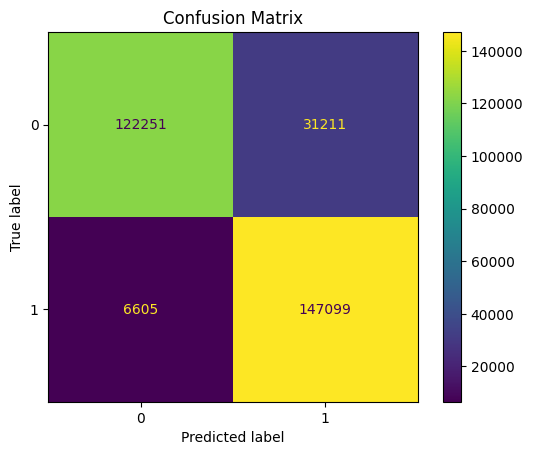

In [17]:
# Create and display confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Generate classification report
report = classification_report(all_targets, all_preds, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.80      0.87    153462
     Class 1       0.82      0.96      0.89    153704

    accuracy                           0.88    307166
   macro avg       0.89      0.88      0.88    307166
weighted avg       0.89      0.88      0.88    307166

